# Ethereum Price Prediction Models

While ARIMA and neural networks machine learning techniques have proven to be quite successful in predicting the stock market, applying them to the more volatile prices of cryptocurrencies may be more challenging given that cryptocurrencies don’t have indexes or indicators like stocks. The project will work to predict the price of Ethereum (ETH) using daily realtime trading features, such as close price, high price, open price, etc., and more global features such as google searches per day, the price of Bitcoin, the values of the US dollar and Euro, and the number of active addresses that may serve as a sort of index for price prediction. The goal is to give a clear indication as to when to buy and sell Ethereum to maximize one’s return.

## Set Up and Import Data

In [ ]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse, mse
from sklearn.preprocessing import normalize, scale, StandardScaler
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output
clear_output()

### Ethereum and Bitcoin Data
From cryptocompare.com and etherscan.io

In [ ]:
eth_request = "XXX'
btc_request = 'XXX'

eth_import = requests.get(eth_request)
eth_df = pd.DataFrame(json.loads(eth_import.content)['Data'])
eth_df.set_index('time', inplace=True)
eth_df.index = pd.to_datetime(eth_df.index, unit='s')
eth_df.drop(columns=['conversionType', 'conversionSymbol'], inplace=True)
eth_df.columns = ['eth_'+ str(col) for col in eth_df.columns]

btc_import = requests.get(btc_request)
btc_df = pd.DataFrame(json.loads(btc_import.content)['Data'])
btc_df.set_index('time', inplace=True)
btc_df.index = pd.to_datetime(btc_df.index, unit='s')
btc_df.drop(columns=['conversionType', 'conversionSymbol'], inplace=True)
btc_df.columns = ['btc_'+ str(col) for col in btc_df.columns]

In [ ]:
display(eth_df)
btc_df

,eth_high,eth_low,eth_open,eth_volumefrom,eth_volumeto,eth_close
time,,,,,,
2016-12-20,7.888,7.540,7.591,367483.99,2.789443e+06,7.591
2016-12-21,8.049,7.795,7.591,715801.15,5.635752e+06,7.873
2016-12-22,8.189,7.350,7.873,1467898.68,1.121579e+07,7.641
2016-12-23,8.143,7.085,7.641,1850158.23,1.321044e+07,7.140
2016-12-24,7.399,6.852,7.140,659415.70,4.771782e+06,7.236
...,...,...,...,...,...,...
2021-01-24,1400.200,1221.780,1234.100,1164242.17,1.540273e+09,1392.450
2021-01-25,1475.490,1296.020,1392.450,1477949.16,2.072432e+09,1318.470
2021-01-26,1378.060,1246.490,1318.470,1325006.34,1.749379e+09,1368.220


,btc_high,btc_low,btc_open,btc_volumefrom,btc_volumeto,btc_close
time,,,,,,
2016-12-20,800.02,787.12,789.79,34480.19,2.740632e+07,799.10
2016-12-21,833.13,795.98,799.10,65293.55,5.341108e+07,829.21
2016-12-22,874.68,828.87,829.21,70557.59,6.051162e+07,860.15
2016-12-23,920.26,858.04,860.15,102224.08,9.180293e+07,917.17
2016-12-24,920.49,880.79,917.17,46030.07,4.157678e+07,891.07
...,...,...,...,...,...,...
2021-01-24,33090.99,30957.56,32107.29,33650.76,1.079876e+09,32283.66
2021-01-25,34881.18,31937.09,32283.66,59529.49,1.989618e+09,32275.27
2021-01-26,32943.69,30853.17,32275.27,59770.06,1.909630e+09,32516.52


In [ ]:
# https://etherscan.io/chart/address

PATH = '/content/drive/MyDrive/Thinkful/Capstone Projects/Capstone Final/active-addresses.json'

active_address_df = pd.read_json(PATH)
active_address_df['t'] = active_address_df['t'].str[:10]
active_address_df['t'] = pd.to_datetime(active_address_df['t'])
active_address_df.set_index('t', inplace=True)
active_address_df = active_address_df.rename(columns={'v':'daily_active_addresses'})

active_address_df

,daily_active_addresses
t,
2015-07-30,0
2015-07-31,0
2015-08-01,0
2015-08-02,0
2015-08-03,0
...,...
2021-01-13,460089
2021-01-14,489941
2021-01-15,507082


In [ ]:
# https://etherscan.io/chart/address

PATH = '/content/drive/MyDrive/Thinkful/Capstone Projects/Capstone Final/export-AddressCount.csv'

address_count_df = pd.read_csv(PATH)
address_count_df['Date(UTC)'] = pd.to_datetime(address_count_df['Date(UTC)'])
address_count_df.set_index('Date(UTC)', inplace=True)
address_count_df.rename(columns={'Value': 'total_address_count'}, inplace=True)
address_count_df.drop(columns=['UnixTimeStamp'], inplace=True)
address_count_df['daily_new_addresses'] = address_count_df['total_address_count'].diff()
address_count_df.drop(columns='total_address_count', inplace=True)
address_count_df

,daily_new_addresses
Date(UTC),
2015-07-30,NaN
2015-07-31,156.0
2015-08-01,115.0
2015-08-02,87.0
2015-08-03,76.0
...,...
2021-01-13,159276.0
2021-01-14,155794.0
2021-01-15,151626.0


### Google Trend Data


In [ ]:
# google trends (https://scholar.smu.edu/cgi/viewcontent.cgi?article=1039&context=datasciencereview)

PATH = '/content/drive/MyDrive/Thinkful/Capstone Projects/Capstone Final/google_trend_worldwide_5yr.csv'

googletrend_df = pd.read_csv(PATH)
googletrend_df.columns = ['google_trend']
googletrend_df = googletrend_df[1:]
googletrend_df = googletrend_df.astype('int64')
googletrend_df.index = pd.to_datetime(googletrend_df.index)
googletrend_df

,google_trend
2016-01-24,1
2016-01-31,1
2016-02-07,2
2016-02-14,2
2016-02-21,2
...,...
2020-12-13,21
2020-12-20,22
2020-12-27,40
2021-01-03,100


### US Dollar and Euro Index Data

In [ ]:
# US Dollar Index Futures Historical Data

PATH = '/content/drive/MyDrive/Thinkful/Capstone Projects/Capstone Final/US Dollar Index Futures Historical Data.csv'

USDI_df = pd.read_csv(PATH)
USDI_df['Date'] = pd.to_datetime(USDI_df['Date'])
USDI_df.index = USDI_df['Date']
USDI_df['USDI_daily'] = (USDI_df['Low'] + USDI_df['High'])/2
USDI_df = USDI_df['USDI_daily']
USDI_df

Date
2021-01-18     90.8265
2021-01-15     90.4925
2021-01-14     90.3050
2021-01-13     90.1625
2021-01-12     90.2975
                ...   
2017-01-09    102.1675
2017-01-06    101.8475
2017-01-05    101.8975
2017-01-04    102.9025
2017-01-03    103.2200
Name: USDI_daily, Length: 1043, dtype: float64

In [ ]:
# Euro Index Historical Data

PATH = '/content/drive/MyDrive/Thinkful/Capstone Projects/Capstone Final/Investing.com Euro Index Historical Data.csv'
EI_df = pd.read_csv(PATH)
EI_df['Date'] = pd.to_datetime(EI_df['Date'])
EI_df.index = EI_df['Date']
EI_df['EI_daily'] = (EI_df['Low'] + EI_df['High'])/2
EI_df = EI_df['EI_daily']
EI_df

Date
2021-01-18    107.095
2021-01-17    107.305
2021-01-15    107.470
2021-01-14    107.625
2021-01-13    107.795
               ...   
2017-01-05     86.600
2017-01-04     86.115
2017-01-03     85.970
2017-01-02     86.410
2017-01-01     86.635
Name: EI_daily, Length: 1286, dtype: float64

### Join Data

In [ ]:
ethereum = pd.DataFrame()
ethereum['Date'] = pd.date_range(start='01/01/17', end='01/10/21')
ethereum.index = ethereum.Date
ethereum = ethereum.join([eth_df, active_address_df, address_count_df, btc_df, googletrend_df, USDI_df, EI_df], how='left')

ethereum

,Date,eth_high,eth_low,eth_open,eth_volumefrom,eth_volumeto,eth_close,daily_active_addresses,daily_new_addresses,btc_high,btc_low,btc_open,btc_volumefrom,btc_volumeto,btc_close,google_trend,USDI_daily,EI_daily
Date,,,,,,,,,,,,,,,,,,
2017-01-01,2017-01-01,8.891,7.970,8.018,854000.05,6.963217e+06,8.154,13695.0,1606.0,1001.61,956.10,963.38,41148.52,4.057092e+07,995.44,3.0,NaN,86.635
2017-01-02,2017-01-02,8.568,7.964,8.154,859902.07,7.152179e+06,8.317,14916.0,2248.0,1031.68,990.20,995.44,64951.63,6.603807e+07,1017.05,NaN,NaN,86.410
2017-01-03,2017-01-03,9.940,8.185,8.335,571218.00,5.292232e+06,9.595,14612.0,2661.0,1035.47,1006.53,1017.05,54788.01,5.608587e+07,1033.30,NaN,103.2200,85.970
2017-01-04,2017-01-04,11.500,10.240,9.639,2063444.32,2.269524e+07,11.000,17688.0,3527.0,1148.54,1022.32,1033.30,156272.17,1.705846e+08,1135.41,NaN,102.9025,86.115
2017-01-05,2017-01-05,10.370,9.151,11.000,2134380.99,2.160218e+07,10.120,18556.0,3319.0,1150.63,874.53,1135.41,240007.84,2.448393e+08,989.35,NaN,101.8975,86.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-06,2021-01-06,1214.120,1059.190,1103.190,2484714.82,2.817165e+09,1210.590,533812.0,159940.0,36973.76,33404.20,34038.29,108190.73,3.788317e+09,36849.86,NaN,89.4800,108.450
2021-01-07,2021-01-07,1290.460,1151.600,1210.590,1601329.30,1.957429e+09,1225.500,572564.0,163865.0,40365.87,36340.01,36849.86,124086.76,4.753170e+09,39479.41,NaN,89.6475,108.350
2021-01-08,2021-01-08,1273.690,1067.330,1225.500,1767634.41,2.103291e+09,1216.980,533554.0,167231.0,41964.96,36640.51,39479.41,118077.27,4.705592e+09,40636.24,NaN,89.9275,108.180


## Clean & Explore Data

In [ ]:
ethereum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1471 entries, 2017-01-01 to 2021-01-10
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    1471 non-null   datetime64[ns]
 1   eth_high                1471 non-null   float64       
 2   eth_low                 1471 non-null   float64       
 3   eth_open                1471 non-null   float64       
 4   eth_volumefrom          1471 non-null   float64       
 5   eth_volumeto            1471 non-null   float64       
 6   eth_close               1471 non-null   float64       
 7   daily_active_addresses  1471 non-null   float64       
 8   daily_new_addresses     1471 non-null   float64       
 9   btc_high                1471 non-null   float64       
 10  btc_low                 1471 non-null   float64       
 11  btc_open                1471 non-null   float64       
 12  btc_volumefrom          1471 n

Google trends only provides weekly data, so we'll interpolate in order to show a sort of daily trend. USDI and EI miss certain days (like weekends and holidays), so interpolation seems to be the best method for filling in those null values as well.

In [ ]:
ethereum = ethereum.interpolate(method='linear', limit_direction='both')
ethereum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1471 entries, 2017-01-01 to 2021-01-10
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    1471 non-null   datetime64[ns]
 1   eth_high                1471 non-null   float64       
 2   eth_low                 1471 non-null   float64       
 3   eth_open                1471 non-null   float64       
 4   eth_volumefrom          1471 non-null   float64       
 5   eth_volumeto            1471 non-null   float64       
 6   eth_close               1471 non-null   float64       
 7   daily_active_addresses  1471 non-null   float64       
 8   daily_new_addresses     1471 non-null   float64       
 9   btc_high                1471 non-null   float64       
 10  btc_low                 1471 non-null   float64       
 11  btc_open                1471 non-null   float64       
 12  btc_volumefrom          1471 n

For our models to come, a daily price for both Ethereum and Bitcoin may prove valuable, so we'll use the OHLC average (i.e. open, high, low, close average) to compute these two features. The other bitcoin features will then be dropped.

In [ ]:
ethereum['eth_daily_price'] = (ethereum.eth_open + ethereum.eth_close +
                            ethereum.eth_high + ethereum.eth_low) / 4
ethereum['btc_daily_price'] = (ethereum.btc_open + ethereum.btc_close +
                               ethereum.btc_high + ethereum.btc_low)
ethereum.drop(columns=btc_df.columns, inplace=True)
ethereum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1471 entries, 2017-01-01 to 2021-01-10
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    1471 non-null   datetime64[ns]
 1   eth_high                1471 non-null   float64       
 2   eth_low                 1471 non-null   float64       
 3   eth_open                1471 non-null   float64       
 4   eth_volumefrom          1471 non-null   float64       
 5   eth_volumeto            1471 non-null   float64       
 6   eth_close               1471 non-null   float64       
 7   daily_active_addresses  1471 non-null   float64       
 8   daily_new_addresses     1471 non-null   float64       
 9   google_trend            1471 non-null   float64       
 10  USDI_daily              1471 non-null   float64       
 11  EI_daily                1471 non-null   float64       
 12  eth_daily_price         1471 n

In [ ]:
ethereum_norm = pd.DataFrame(normalize(ethereum[ethereum.columns[1:]], norm='max', axis=0))
ethereum_norm.columns = ethereum.columns[1:]
ethereum_norm.index = ethereum.index

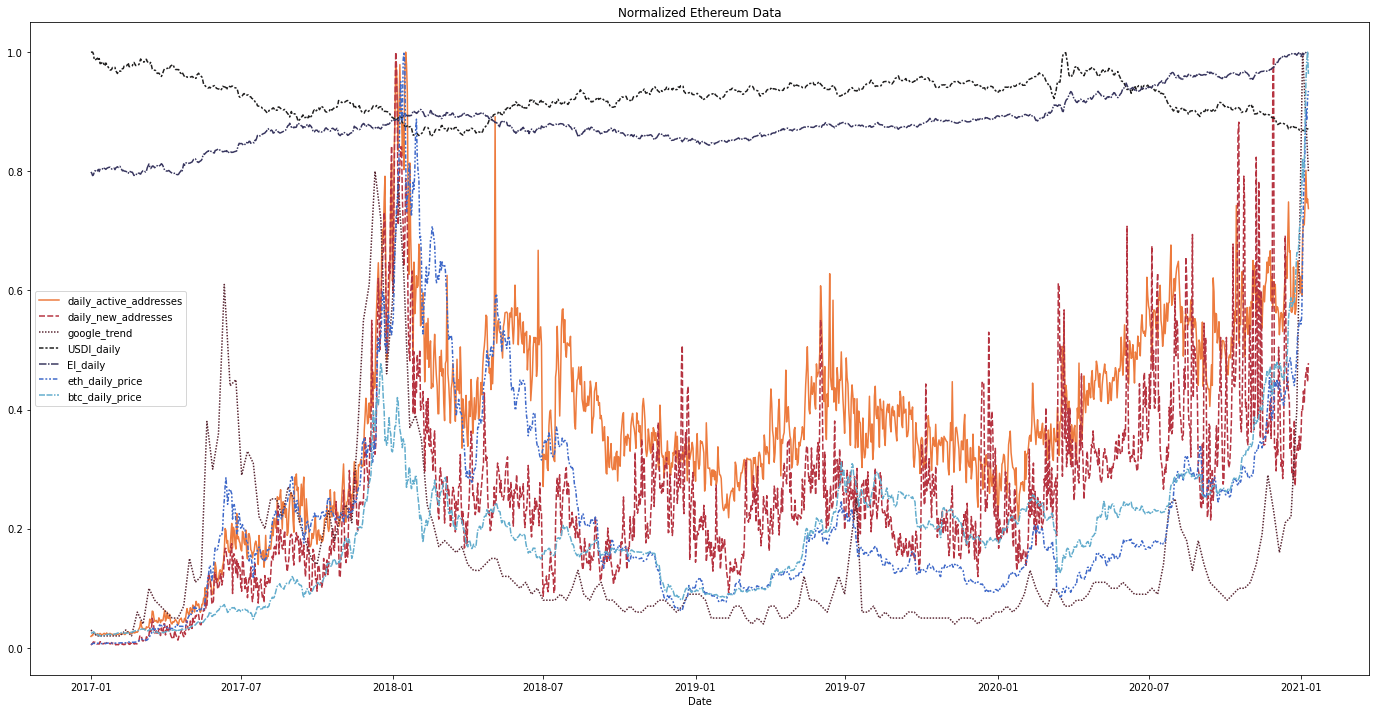

In [ ]:
plt.figure(figsize=(24,12))
plt.title('Normalized Ethereum Data')
sns.lineplot(data=ethereum_norm[ethereum_norm.columns[6:]], palette='icefire_r')
plt.show()

Right off the bat, some interesting trends arise. We can see that ETH generally follows google trend data (although it looks a little offset at places) and BTC price. While the correlation with EI daily isn't as strong, the both appear to change together while ETH moved in the general opposite direction of the USDI. It might be more useful to look at how the slope of the total address count correlates with ETH price versus just the running total - likewise for the USDI and EI. However, let's start with an ARIMA model to see if anything else can be gleaned and to set a baseline for our deep learning model to come.

## ARIMA

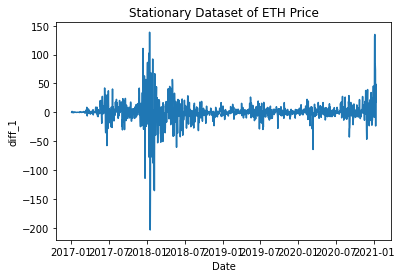

In [ ]:
eth_arima = pd.DataFrame(ethereum['eth_daily_price'])
eth_arima['diff_1'] = eth_arima.eth_daily_price - eth_arima.eth_daily_price.shift(periods=1)

plt.figure()
plt.title('Stationary Dataset of ETH Price')
sns.lineplot(data=eth_arima.diff_1, palette='icefire_r')
plt.show()

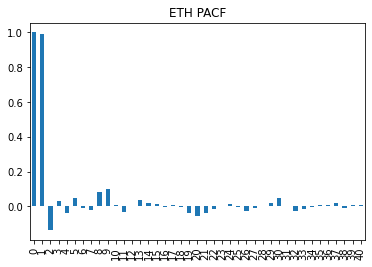

In [ ]:
x_pacf = pd.DataFrame(pacf(eth_arima.eth_daily_price))
x_pacf.plot(kind='bar')
plt.title('ETH PACF')
plt.legend().set_visible(False)
plt.show()

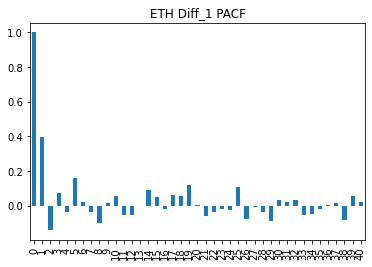

In [ ]:
x_pacf = pd.DataFrame(pacf(eth_arima.diff_1[1:]))
x_pacf.plot(kind='bar')
plt.title('ETH Diff_1 PACF')
plt.legend().set_visible(False)
plt.show()

In [ ]:
test_size = .2
split_row = int((1 - test_size) * len(eth_arima))

X_train = eth_arima.eth_daily_price.iloc[0:split_row]
X_test = eth_arima.eth_daily_price.iloc[split_row:]

In [ ]:
P = []
D = []
Q = []
AIC_list = []
LLH = []

for p in range (1,3):
    for d in range (0,2):
        for q in range (0,3):
            model = ARIMA(X_train, order=(p,d,q))
            model_fit = model.fit()
            P.append(p)
            Q.append(q)
            D.append(d)
            AIC_list.append(model_fit.aic)
            LLH.append(model_fit.llf)
            print(p,d,q)
clear_output()

results = pd.DataFrame()
results['p'] = P
results['d'] = D
results['q'] = Q 
results['AIC'] = AIC_list
results['Log_Likelihood'] = LLH

,p,d,q,AIC,Log_Likelihood
5,1,1,2,10039.246439,-5014.623219
4,1,1,1,10040.037172,-5016.018586
10,2,1,1,10040.333588,-5015.166794
11,2,1,2,10041.227123,-5014.613562
9,2,1,0,10046.608742,-5019.304371
1,1,0,1,10051.217682,-5021.608841
8,2,0,2,10051.550581,-5019.775290
7,2,0,1,10052.433714,-5021.216857
2,1,0,2,10052.548735,-5021.274368
3,1,1,0,10076.641041,-5035.320521


,p,d,q,AIC,Log_Likelihood
11,2,1,2,10041.227123,-5014.613562
5,1,1,2,10039.246439,-5014.623219
10,2,1,1,10040.333588,-5015.166794
4,1,1,1,10040.037172,-5016.018586
9,2,1,0,10046.608742,-5019.304371
8,2,0,2,10051.550581,-5019.775290
7,2,0,1,10052.433714,-5021.216857
2,1,0,2,10052.548735,-5021.274368
1,1,0,1,10051.217682,-5021.608841
3,1,1,0,10076.641041,-5035.320521


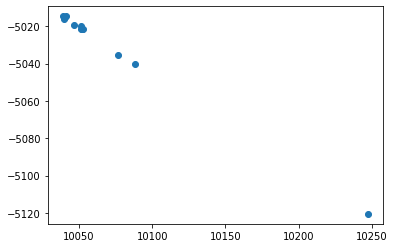

In [ ]:
display(results.sort_values(by='AIC', ascending=True))
display(results.sort_values(by='Log_Likelihood', ascending=False))

plt.scatter(results.AIC, results.Log_Likelihood)
plt.show()

Here I chose the model with the lowest AIC and the highest Log Likelihood to ensure we are keeping as much information as possible from the data in our model and that it is the most probable model to produce the original dataset.

In [ ]:
model_112 = ARIMA(eth_arima.eth_daily_price, order=(1,1,2))
model_112_fit = model_112.fit()

clear_output()

print(model_112_fit.summary())
print('Residuals Description')
print(model_112_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:      D.eth_daily_price   No. Observations:                 1470
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6231.261
Method:                       css-mle   S.D. of innovations             16.776
Date:                Tue, 26 Jan 2021   AIC                          12472.522
Time:                        19:37:35   BIC                          12498.987
Sample:                    01-02-2017   HQIC                         12482.391
                         - 01-10-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.9441      0.877      1.077      0.282      -0.774       2.662
ar.L1.D.eth_daily_price     0.9478      0.047     19.976      0.000       0.855       1.041


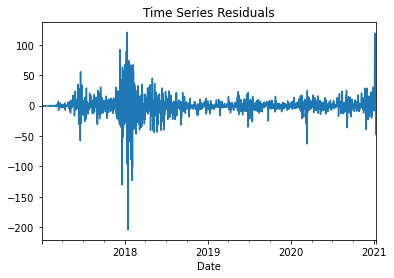

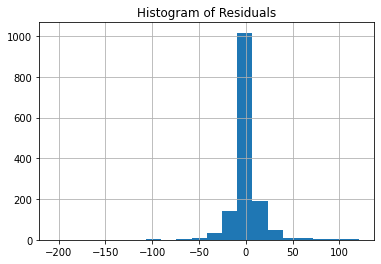

In [ ]:
residuals = pd.DataFrame(model_112_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series Residuals')
residuals.hist(bins=20)
plt.title('Histogram of Residuals')
plt.show()

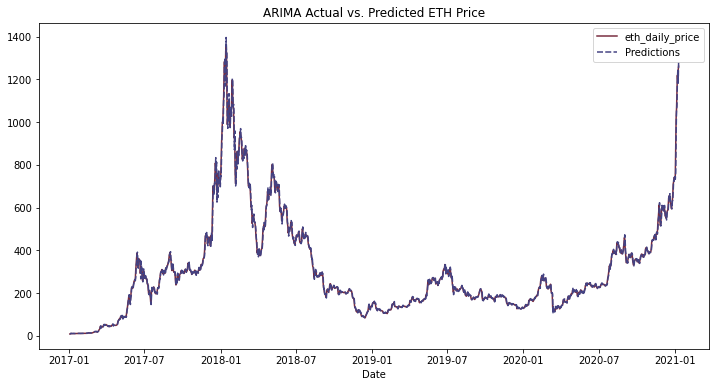

In [ ]:
preds = model_112_fit.predict(typ='levels')
eth_arima['Predictions'] = preds
eth_arima = eth_arima[1:]

plt.figure(figsize=(12,6))
sns.lineplot(data=eth_arima[['eth_daily_price', 'Predictions']], palette='icefire_r')
plt.title('ARIMA Actual vs. Predicted ETH Price')
plt.show()

In [ ]:
rmse(eth_arima['eth_daily_price'], preds)

16.775532905286553

In [ ]:
mean_absolute_error(eth_arima['eth_daily_price'], eth_arima['Predictions'])

8.8181543786442

In [ ]:
# MAPE

np.mean(np.abs((eth_arima['eth_daily_price'] - eth_arima['Predictions']) / eth_arima['eth_daily_price'])*100)

2.8805136867371472

## Deep Learning

This model make predictions based on windows of data. Thus an input window will contain data for a certain amount of time prior to the target day.

In [ ]:
def create_window_data(dataframe, window_len):
    window_data = []
    for x in range(len(dataframe) - window_len):
        window_x = dataframe[x:(x + window_len)]
        window_data.append(window_x.values)
    return np.array(window_data)

In [ ]:
train_data, test_data = train_test_split(ethereum_norm, test_size=0.2, shuffle=False)

In [ ]:
def eth_rnn_model(neurons, lstm_neurons, act, opt, loss, bs, dropout, window_len):
    window_len = window_len

    X_train = create_window_data(train_data, window_len=window_len)
    X_test = create_window_data(test_data, window_len=window_len)
    y_train = train_data['eth_daily_price'][window_len:].values
    y_test = test_data['eth_daily_price'][window_len:].values
    
    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(X_train.shape[1], 
                                              X_train.shape[2])))
    model.add(Dropout(.2))
    model.add(Dense(1, activation=act))
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

    model.fit(X_train, y_train, batch_size=bs, epochs=20, verbose=0)
    return model, X_train, X_test, y_train, y_test

In [ ]:
model, X_train, X_test, y_train, y_test = eth_rnn_model(100, 100, 'relu', 'sgd', 'mse', 32, 0.2, 4)

In [ ]:
targets = ethereum_norm['eth_daily_price'][(-len(X_test)):]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test) * max(ethereum['eth_daily_price'])

59.463136514622896

In [ ]:
neuron_list = [256,128,64]                   # 256 seems the most likely given a first run
activation_list = ['tanh', 'relu']           # definitely not sigmoid
batch_list = [8,32]                          # definitely not 128
window_list = [2,3,4]
results = []
count = 0
np.random.seed(47)

for w in neuron_list:
    for x in neuron_list:
        for y in activation_list:
            for z in batch_list:
                for p in window_list:
                    count+=1
                    print(f'{count}/{len(neuron_list)*len(neuron_list)*len(activation_list)*len(batch_list)*len(window_list)}')
                    
                    model, X_train, X_test, y_train, y_test = eth_rnn_model(w, x, y, 'adam', 'mse', z, .2, p)
                    targets = ethereum_norm['eth_daily_price'][(-len(X_test)):]
                    preds = model.predict(X_test).squeeze()
                    mae = mean_absolute_error(preds, y_test) * max(ethereum['eth_daily_price'])
                    results.append((w,x,y,z,p,mae))
                    clear_output() 

In [ ]:
results_df = pd.DataFrame(results, columns=('LSTM neurons', 'neurons', 'activation_fxn', 'batch_size', 'window_size', 'MAE'))
results_df.sort_values(by='MAE', ascending=True, inplace=True)
results_df.head(50)

,LSTM neurons,neurons,activation_fxn,batch_size,window_size,MAE
43,128,256,relu,8,3,10.176176
80,64,256,relu,8,4,10.554097
7,256,256,relu,8,3,11.248996
0,256,256,tanh,8,2,11.665722
18,256,128,relu,8,2,11.693552
21,256,128,relu,32,2,11.716281
9,256,256,relu,32,2,11.751183
60,128,64,tanh,8,2,11.822749
105,64,64,relu,32,2,12.007062
73,64,256,tanh,8,3,12.036360


In [ ]:
np.random.seed()
mae_list = []
for i in range(0,5):    
    model, X_train, X_test, y_train, y_test = eth_rnn_model(128, 256, 'relu', 'adam', 'mse', 8, 0.2, 3)

    targets = ethereum_norm['eth_daily_price'][(-len(X_test)):]
    preds = model.predict(X_test).squeeze()
    mae = mean_absolute_error(preds, y_test) * max(ethereum['eth_daily_price'])
    mae_list.append(mae)
print(mae_list)
sum(mae_list)/len(mae_list)

[12.673031824161264, 9.18344480362491, 13.213395837238087, 29.42597589038614, 10.674716258617606]


15.034112922805601

In [ ]:
mae_list2 = []
mape_list = []
for i in range(0,5):    
    model, X_train, X_test, y_train, y_test = eth_rnn_model(16, 256, 'relu', 'adam', 'mse', 8, 0.2, 3)

    targets = ethereum_norm['eth_daily_price'][(-len(X_test)):]
    preds = model.predict(X_test).squeeze()
    mae = mean_absolute_error(preds, y_test) * max(ethereum['eth_daily_price'])
    mae_list2.append(mae)
    mape = np.mean(np.abs((y_test - preds) / y_test)*100)
    mape_list.append(mape)

print('MAE: ', mae_list2)
print(np.mean(mae_list2), ' +/- ', 2*np.std(mae_list2))
print('MAPE: ',mape_list)
print(np.mean(mape_list), ' +/- ', 2*np.std(mape_list))

MAE:  [9.959290075366436, 14.979369124464776, 10.770112395310795, 13.844973524877808, 9.438303661095631]
11.79840975622309  +/-  4.41060387745769
MAPE:  [2.368727454822372, 4.479195067259212, 2.8197954461336674, 3.1478823380141816, 2.4274130893349746]
3.0486026791128813  +/-  1.5380274662332658


Below is our best model based on the above trials and their respective mean absolute error's (not all are shown as the runtimes were particularly long).

In [ ]:
model, X_train, X_test, y_train, y_test = eth_rnn_model(16, 256, 'relu', 'adam', 'mse', 8, 0.2, 3)

targets = ethereum_norm['eth_daily_price'][(-len(X_test)):]
preds_rnn = model.predict(X_test).squeeze()
mae = mean_absolute_error(preds_rnn, y_test) * max(ethereum['eth_daily_price'])
mape = np.mean(np.abs((y_test - preds_rnn) / y_test)*100)
print(mae)
print(mape)

10.564879613656107
3.0250662789760883


In [ ]:
preds_rnn_train = model.predict(X_train).squeeze()
mae = mean_absolute_error(preds_rnn_train, y_train) * max(ethereum['eth_daily_price'])
mape = np.mean(np.abs((y_train - preds_rnn_train) / y_train)*100)
print(mae)
print(mape)

13.585730996690774
9.945063216342826


We are not overfit. The MAPE and MAE for the test set are surprisingly lower than that of the training set. 

In [ ]:
residuals_rnn = np.array(y_test - preds_rnn)

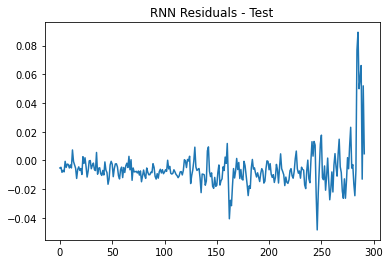

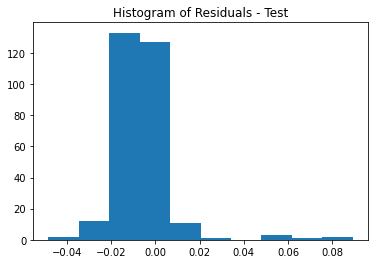

In [ ]:
plt.plot(residuals_rnn)
plt.title('RNN Residuals - Test')
plt.show()
plt.hist(residuals_rnn)
plt.title('Histogram of Residuals - Test')
plt.show()

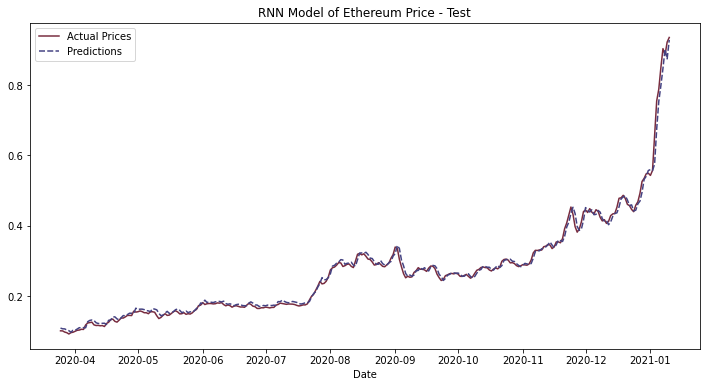

In [ ]:
rnn_data = pd.DataFrame()
rnn_data['Actual Prices'] = y_test
rnn_data['Predictions'] = preds_rnn
rnn_data['Date'] = pd.date_range(start='03/25/20', end='01/10/21')
rnn_data.index = rnn_data.Date

plt.figure(figsize=(12,6))
plt.title('RNN Model of Ethereum Price - Test')
sns.lineplot(data=rnn_data[['Actual Prices', 'Predictions']], palette='icefire_r')
plt.show()

## Conclusions

While the deep learning model deploying an RNN network worked well to predict the daily price of Ethereum, all efforts to tune hyperparameters and the model were not quite able to beat the ARIMA model.

Both models show nearly zero centered histograms of their residuals and there is no clear trend. The intent of the deep learning RNN model was to help explain the areas of higher volitility shown in the ARIMA model. This is the biggest area of improvement that I see. Having tuned the RNN model as best as possible, it seems clear that to utterly outperform the ARIMA model, different or additional non-time series features are needed to explain the highly volitile nature of Ethereum cryptocurrency.

This is not to say that this project was not successful! The ARIMA model showing a MAPE of 2.88% (as compared to ~3$\pm$1.5% achieved with the RNN above - note MAPE is used because the scales of data are different) is still a solid deliverable. Assuming an investor knows his or her cost basis of currently owned Ethereum - i.e. how much was originally invested - this percent error can be reasonably built in as a sort of buffer for the next days choice of what to buy or sell.

In a production environment, this ARIMA model can be continuously updated daily and have it's p, d, and q adjusted as needed in the same way shown in this notebook. With a given cost basis and known mean average error (here, 8.8) that can be used as buffer to ensure a successful, profitable transactions, the next days prediction can be used to provide recommendations to either hold, sell, or buy additional Ethereum. 